In [21]:
%load_ext autoreload
%autoreload 2
import extract_environment as ee
import time
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
dir_env = '/home/kbrennan/phd/data/climate/present'
dir_track = '/home/kbrennan/phd/data/climate/tracks/present'
day = '20210628'

now = pd.to_datetime(day+'15', format='%Y%m%d%H')

In [23]:
cells = ee.load_cells(dir_track, day)

In [24]:
for cell in cells:
    print(cell['cell_id'],cell['lifespan'])

0 40.0
1 65.0
2 120.0
3 40.0
4 55.0
5 45.0
6 80.0
7 40.0
8 45.0
9 55.0
10 95.0
11 115.0
12 60.0
13 45.0
14 55.0
15 225.0
16 50.0
17 75.0
18 30.0
19 80.0
20 55.0
21 40.0
22 30.0
23 205.0
24 50.0
25 30.0
26 50.0
27 110.0
28 130.0
29 50.0
30 60.0
31 35.0
32 30.0
33 60.0
34 30.0
35 70.0
36 30.0
37 35.0
38 70.0
39 70.0
40 45.0
41 50.0
42 30.0
43 45.0
44 60.0
45 40.0
46 85.0
47 35.0
48 55.0
49 30.0
50 100.0
51 45.0
52 50.0
53 65.0
54 70.0
55 175.0
56 35.0
57 50.0
58 45.0
59 70.0
60 60.0
61 60.0
62 50.0
63 35.0
64 55.0


In [25]:
cell = cells[15]

In [26]:
cell.keys()

dict_keys(['cell_id', 'parent', 'child', 'merged_to', 'died_of', 'lifespan', 'datelist', 'lon', 'lat', 'mass_center_x', 'mass_center_y', 'max_x', 'max_y', 'delta_x', 'delta_y', 'area_gp', 'max_val', 'score'])

In [27]:
env = ee.load_environments(dir_env, now)

In [28]:
dir_cookie = "/home/kbrennan/phd/data/climate/cookies/present/cookie_20210628_0015.nc"
cookie = xr.open_dataset(dir_cookie)

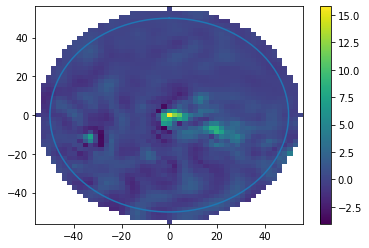

In [29]:
plt.pcolormesh(cookie.x,cookie.y,cookie.W.sel(pressure=40000).isel(time=0))
# plot circle
circle = plt.plot(np.sin(np.linspace(0,2*np.pi,100))*50,np.cos(np.linspace(0,2*np.pi,100))*50)
plt.colorbar()

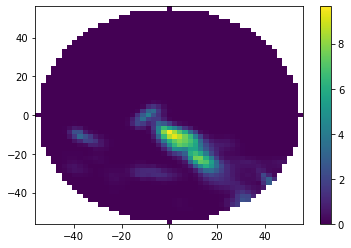

In [30]:
plt.pcolormesh(cookie.x,cookie.y,cookie.TOT_PREC.isel(time=1))
plt.colorbar()